# Human in the loop/ Hooman Feedback in the loop
- In the ReAct pattern the chatbot can performs an operation using a tool like tavily to search for information and then use that information to answer the user.
- Then we can setup a toolcall which asks for human feedback and then uses that feedback to improve the chatbot.
![image](../imgs/image1.png)

- in the human interaction, we get an interrupt. here we can provide the option to stop or continue.

In [52]:
import os
from dotenv import load_dotenv
load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")


In [53]:
from langchain.chat_models import init_chat_model
llm = init_chat_model(model = "groq:qwen/qwen3-32b")


In [54]:
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 16384, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000029E79FF7E30>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000029E7A0FBD70>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [55]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder= StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human"""
    human_response = interrupt({
        'query': query
    })
    return human_response['data']

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state['messages'])
    # as we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating
    # any tool invocations when we resume.

    return {
        'messages' : [message]
    }

graph_builder.add_node('chatbot', chatbot)

tool_node = ToolNode(tools)
graph_builder.add_node('tools', tool_node)

graph_builder.add_conditional_edges('chatbot', tools_condition)
graph_builder.add_edge('tools', 'chatbot')
graph_builder.add_edge(START, 'chatbot')
graph_builder.add_edge('chatbot', END)

graph = graph_builder.compile()


In [56]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

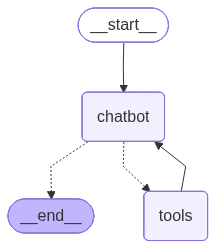

In [57]:
graph

In [58]:
user_input = 'I need some expert assistance and guidance for building an AI agent. Could you request Assustance for me?'
config = {
    'configurable': {
        'thread_id': '2'
    }
}

events = graph.stream({
    'messages' : user_input
}, config, stream_mode='values')

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()
        # print(event['messages'][-1].pretty_print())

================================ Human Message =================================

I need some expert assistance and guidance for building an AI agent. Could you request Assustance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (hdqq0jmwf)
 Call ID: hdqq0jmwf
  Args:
    query: I need expert guidance on building an AI agent. Can you help with architecture design, implementation strategies, and best practices for developing intelligent autonomous systems?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (hdqq0jmwf)
 Call ID: hdqq0jmwf
  Args:
    query: I need expert guidance on building an AI agent. Can you help with architecture design, implementation strategies, and best practices for developing intelligent autonomous systems?


In [59]:
human_response = (
    "We are the experts are here to help! We'd recommend to check out the langgraph to build your agent."
    "It is much more reliable and extensible than simple autonomous agents"
)

human_command = Command(resume = {
    'data': human_response
})

events = graph.stream(human_command, config, stream_mode="values")

for event in events:
   if 'messages' in event:
        event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (hdqq0jmwf)
 Call ID: hdqq0jmwf
  Args:
    query: I need expert guidance on building an AI agent. Can you help with architecture design, implementation strategies, and best practices for developing intelligent autonomous systems?
================================= Tool Message =================================
Name: human_assistance

We are the experts are here to help! We'd recommend to check out the langgraph to build your agent.It is much more reliable and extensible than simple autonomous agents
================================== Ai Message ==================================

LangGraph is an excellent choice for building AI agents! It's part of the LangChain ecosystem and offers several advantages over basic autonomous agent implementations:

1. **Structured Workflows**: Enables creation of stateful, graph-based workflows with clear execution paths
2. **Modular Components